In [1]:
import numpy as np
import torch
import torch.nn as nn

from datasets.posetrack21 import PoseTrack21
from utilities.utilities import keypoints_to_mask, accuracy, show_image, HiddenPrints, show_heatmaps, keypoints_to_label_flag
from mmpose.evaluation import pose_pck_accuracy, keypoint_pck_accuracy
from mmpose.codecs import UDPHeatmap
from models.backbone.vit_with_fusion import FusionVit
from models.head.deconv import DeconvHead
from models.PoseEstimate import PoseEstimate
from models.head import MaskHead, ResMaskHead

In [2]:
# device = "cpu"
device = "cuda"
pretrained_path = "./checkpoints/vitpose_base_coco_aic_mpii.pth"
encoder = FusionVit(pretrained_path=pretrained_path)
neck = nn.Identity()
head = ResMaskHead(pretrained_path=pretrained_path)
model = PoseEstimate(encoder=encoder, neck=neck, head=head)
model.to(device)
model_path = "./checkpoints/Fusion_ResMask_01.pth"
# model_path = "./checkpoints/dvitpose_best_01.pth"
model_dict = torch.load(model_path, map_location=device)
model.load_state_dict(model_dict["model_state_dict"])
epoch = model_dict["epoch"]
print(f"Loaded model from {model_path} at epoch {epoch}")
with HiddenPrints():
    model.to(device)
    model.eval()

Loaded model from ./checkpoints/Fusion_ResMask_01.pth at epoch 1280


In [3]:
dataset_root_dir = "/home/junfeng/datasets/PoseTrack21"
dataset_train = PoseTrack21(
    root_dir=dataset_root_dir,
    set="train",
)

dataset_test = PoseTrack21(
    root_dir=dataset_root_dir,
    set="test",
)

print(len(dataset_train))
print(len(dataset_test))

593
170


In [4]:
dataset = dataset_test
loss_val = 0
mean_avg_acc_udp = 0
mean_avg_acc = 0
count = 0
thr = 0.05
while count < 5000:
    count += 1
    i = np.random.randint(0, len(dataset))
    video, video_transformed, keypoints, keypoints_transformed, heatmaps = dataset[i]
    mask = keypoints_to_mask(keypoints)
    image = video[1]
    decoder = UDPHeatmap(input_size=(192, 256), heatmap_size=(48, 64))
    image_transformed = video_transformed[1]
    video_transformed = video_transformed.to(device).unsqueeze(0)
    heatmaps = heatmaps.cpu().numpy()
    with torch.no_grad():
        pred_heatmaps = model.predict(video_transformed)
        pred_heatmaps = pred_heatmaps.cpu().numpy()
        _, avg_acc, _ = pose_pck_accuracy(
            pred_heatmaps, heatmaps, mask, thr=thr)
        mean_avg_acc += avg_acc
        pred_heatmaps = pred_heatmaps.squeeze()
        pred_keypoints = decoder.decode(pred_heatmaps)[0]
        normalize = np.tile(np.array([[256, 192]]), (1, 1))
        _, avg_acc_udp, _ = keypoint_pck_accuracy(
            pred=pred_keypoints, gt=keypoints_transformed[:, :2].numpy(), mask=mask, thr=thr, norm_factor=normalize)
        mean_avg_acc_udp += avg_acc_udp
        print(
            f"count: {count}, mean_avg_acc_udp: {mean_avg_acc_udp / count}, mean_avg_acc {mean_avg_acc / count}", end="\r")

In [5]:
dataset = dataset_test
loss_val = 0
mean_avg_acc_udp = 0
mean_avg_acc = 0
count = 0
thr = 0.05
while count < 5000:
    count += 1
    i = np.random.randint(0, len(dataset))
    video, video_transformed, keypoints, keypoints_transformed, heatmaps = dataset[i]
    mask = keypoints_to_mask(keypoints)
    image = video[1]
    decoder = UDPHeatmap(input_size=(192, 256), heatmap_size=(48, 64))
    image_transformed = video_transformed[1]
    video_transformed = video_transformed.to(device).unsqueeze(0)
    heatmaps = heatmaps.cpu().numpy()
    with torch.no_grad():
        pred_heatmaps = model.predict(video_transformed)
        pred_heatmaps = model.denoise(video_transformed, pred_heatmaps)
        pred_heatmaps = pred_heatmaps.cpu().numpy()
        _, avg_acc, _ = pose_pck_accuracy(
            pred_heatmaps, heatmaps, mask, thr=thr)
        mean_avg_acc += avg_acc
        pred_heatmaps = pred_heatmaps.squeeze()
        pred_keypoints = decoder.decode(pred_heatmaps)[0]
        normalize = np.tile(np.array([[256, 192]]), (1, 1))
        _, avg_acc_udp, _ = keypoint_pck_accuracy(
            pred=pred_keypoints, gt=keypoints_transformed[:, :2].numpy(), mask=mask, thr=thr, norm_factor=normalize)
        mean_avg_acc_udp += avg_acc_udp
        print(
            f"count: {count}, mean_avg_acc_udp: {mean_avg_acc_udp / count}, mean_avg_acc {mean_avg_acc / count}", end="\r")

In [10]:
dataset = dataset_test
loss_val = 0
mean_avg_acc_udp = 0
mean_avg_acc = 0
count = 0
thr = 0.05
while count < 5000:
    count += 1
    i = np.random.randint(0, len(dataset))
    video, video_transformed, keypoints, keypoints_transformed, heatmaps = dataset[i]
    mask = keypoints_to_mask(keypoints)
    image = video[1]
    decoder = UDPHeatmap(input_size=(192, 256), heatmap_size=(48, 64))
    image_transformed = video_transformed[1]
    video_transformed = video_transformed.to(device).unsqueeze(0)
    heatmaps = heatmaps.cpu().numpy()
    with torch.no_grad():
        pred_heatmaps = model.predict(video_transformed)
        pred_heatmaps = model(video_transformed, pred_heatmaps)
        pred_heatmaps = pred_heatmaps.cpu().numpy()
        _, avg_acc, _ = pose_pck_accuracy(
            pred_heatmaps, heatmaps, mask, thr=thr)
        mean_avg_acc += avg_acc
        pred_heatmaps = pred_heatmaps.squeeze()
        pred_keypoints = decoder.decode(pred_heatmaps)[0]
        normalize = np.tile(np.array([[256, 192]]), (1, 1))
        _, avg_acc_udp, _ = keypoint_pck_accuracy(
            pred=pred_keypoints, gt=keypoints_transformed[:, :2].numpy(), mask=mask, thr=thr, norm_factor=normalize)
        mean_avg_acc_udp += avg_acc_udp
        print(
            f"count: {count}, mean_avg_acc_udp: {mean_avg_acc_udp / count}, mean_avg_acc {mean_avg_acc / count}", end="\r")

In [6]:
dataset = dataset_test
mean_avg_acc_udp = 0
mean_avg_acc = 0
count = 0
thr = 0.05
for i in range(len(dataset)):
    for video, video_transformed, expanded_bbox, keypoints, heatmaps, image_id, track_id in dataset.get_for_eval(i):
        count += 1
        mask = keypoints_to_mask(keypoints)
        image = video[1]
        decoder = UDPHeatmap(input_size=(192, 256), heatmap_size=(48, 64))
        image_transformed = video_transformed[1]
        video_transformed = video_transformed.to(device).unsqueeze(0)
        heatmaps = heatmaps.cpu().numpy()
        with torch.no_grad():
            pred_heatmaps = model.predict(video_transformed)
            pred_heatmaps = pred_heatmaps.cpu().numpy()
            _, avg_acc, _ = pose_pck_accuracy(
                pred_heatmaps, heatmaps, mask, thr=thr)
            mean_avg_acc += avg_acc
            pred_heatmaps = pred_heatmaps.squeeze()
            pred_keypoints = decoder.decode(pred_heatmaps)[0]
            normalize = np.tile(np.array([[256, 192]]), (1, 1))
            _, avg_acc_udp, _ = keypoint_pck_accuracy(
                pred=pred_keypoints, gt=keypoints_transformed[:, :2].numpy(), mask=mask, thr=thr, norm_factor=normalize)
            mean_avg_acc_udp += avg_acc_udp
            print(
                f"count: {count}, mean_avg_acc_udp: {mean_avg_acc_udp / count}, mean_avg_acc {mean_avg_acc / count}", end="\r")
    if i == 0:
        break

In [7]:
dataset = dataset_test
mean_avg_acc_udp = 0
mean_avg_acc = 0
count = 0
thr = 0.05
for i in range(len(dataset)):
    for video, video_transformed, expanded_bbox, keypoints, heatmaps, image_id, track_id in dataset.get_for_eval(i):
        count += 1
        mask = keypoints_to_mask(keypoints)
        image = video[1]
        decoder = UDPHeatmap(input_size=(192, 256), heatmap_size=(48, 64))
        image_transformed = video_transformed[1]
        video_transformed = video_transformed.to(device).unsqueeze(0)
        heatmaps = heatmaps.cpu().numpy()
        with torch.no_grad():
            pred_heatmaps = model.predict(video_transformed)
            pred_heatmaps = model.denoise(video_transformed, pred_heatmaps)
            pred_heatmaps = pred_heatmaps.cpu().numpy()
            _, avg_acc, _ = pose_pck_accuracy(
                pred_heatmaps, heatmaps, mask, thr=thr)
            mean_avg_acc += avg_acc
            pred_heatmaps = pred_heatmaps.squeeze()
            pred_keypoints = decoder.decode(pred_heatmaps)[0]
            normalize = np.tile(np.array([[256, 192]]), (1, 1))
            _, avg_acc_udp, _ = keypoint_pck_accuracy(
                pred=pred_keypoints, gt=keypoints_transformed[:, :2].numpy(), mask=mask, thr=thr, norm_factor=normalize)
            mean_avg_acc_udp += avg_acc_udp
            print(
                f"count: {count}, mean_avg_acc_udp: {mean_avg_acc_udp / count}, mean_avg_acc {mean_avg_acc / count}", end="\r")
    if i == 0:
        break

In [13]:
dataset = dataset_test
mean_avg_acc_udp = 0
mean_avg_acc = 0
count = 0
thr = 0.05
for i in range(len(dataset)):
    for video, video_transformed, expanded_bbox, keypoints, heatmaps, image_id, track_id in dataset.get_for_eval(i):
        count += 1
        mask = keypoints_to_mask(keypoints)
        image = video[1]
        decoder = UDPHeatmap(input_size=(192, 256), heatmap_size=(48, 64))
        image_transformed = video_transformed[1]
        video_transformed = video_transformed.to(device).unsqueeze(0)
        heatmaps = heatmaps.cpu().numpy()
        with torch.no_grad():
            pred_heatmaps = model.predict(video_transformed)
            pred_heatmaps = model(video_transformed, pred_heatmaps)
            pred_heatmaps = pred_heatmaps.cpu().numpy()
            _, avg_acc, _ = pose_pck_accuracy(
                pred_heatmaps, heatmaps, mask, thr=thr)
            mean_avg_acc += avg_acc
            pred_heatmaps = pred_heatmaps.squeeze()
            pred_keypoints = decoder.decode(pred_heatmaps)[0]
            normalize = np.tile(np.array([[256, 192]]), (1, 1))
            _, avg_acc_udp, _ = keypoint_pck_accuracy(
                pred=pred_keypoints, gt=keypoints_transformed[:, :2].numpy(), mask=mask, thr=thr, norm_factor=normalize)
            mean_avg_acc_udp += avg_acc_udp
            print(
                f"count: {count}, mean_avg_acc_udp: {mean_avg_acc_udp / count}, mean_avg_acc {mean_avg_acc / count}", end="\r")
    if i == 0:
        break

In [14]:
dataset = dataset_test
mean_avg_acc_udp = 0
mean_avg_acc = 0
count = 0
thr = 0.05
for i in range(len(dataset)):
    for video, video_transformed, expanded_bbox, keypoints, heatmaps, image_id, track_id in dataset.get_for_eval(i):
        count += 1
        mask = keypoints_to_mask(keypoints)
        image = video[1]
        decoder = UDPHeatmap(input_size=(192, 256), heatmap_size=(48, 64))
        image_transformed = video_transformed[1]
        video_transformed = video_transformed.to(device).unsqueeze(0)
        heatmaps = heatmaps.cpu().numpy()
        with torch.no_grad():
            pred_heatmaps = model.predict(video_transformed)
            pred_heatmaps = model(video_transformed, pred_heatmaps)
            pred_heatmaps = model(video_transformed, pred_heatmaps)
            pred_heatmaps = pred_heatmaps.cpu().numpy()
            _, avg_acc, _ = pose_pck_accuracy(
                pred_heatmaps, heatmaps, mask, thr=thr)
            mean_avg_acc += avg_acc
            pred_heatmaps = pred_heatmaps.squeeze()
            pred_keypoints = decoder.decode(pred_heatmaps)[0]
            normalize = np.tile(np.array([[256, 192]]), (1, 1))
            _, avg_acc_udp, _ = keypoint_pck_accuracy(
                pred=pred_keypoints, gt=keypoints_transformed[:, :2].numpy(), mask=mask, thr=thr, norm_factor=normalize)
            mean_avg_acc_udp += avg_acc_udp
            print(
                f"count: {count}, mean_avg_acc_udp: {mean_avg_acc_udp / count}, mean_avg_acc {mean_avg_acc / count}", end="\r")
    if i == 0:
        break

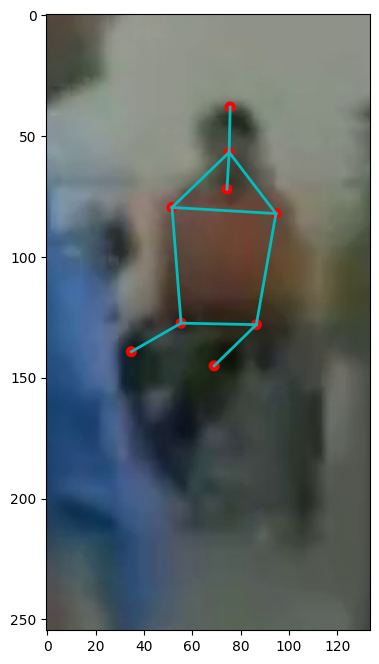

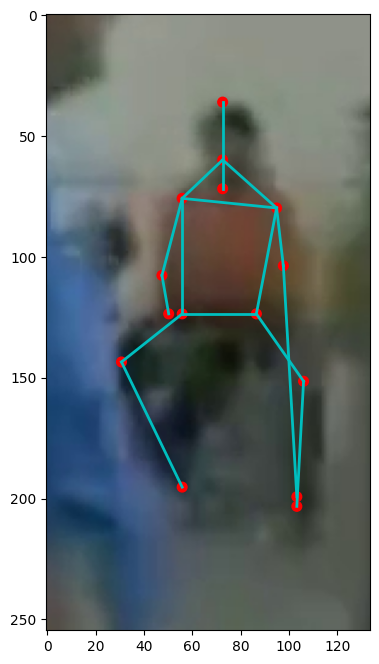

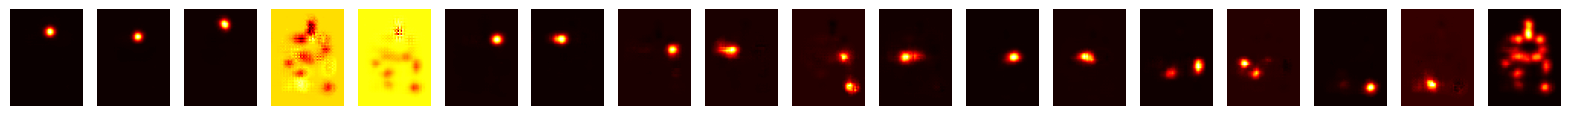

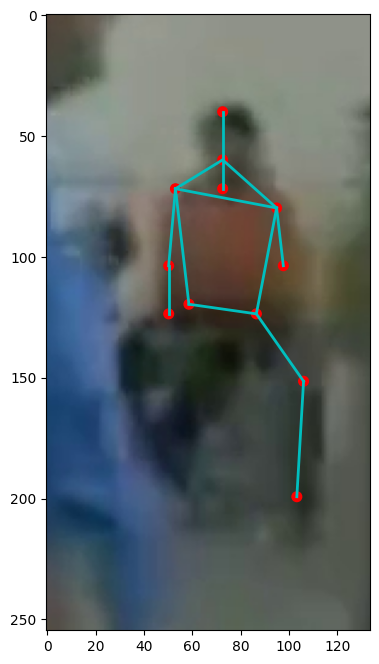

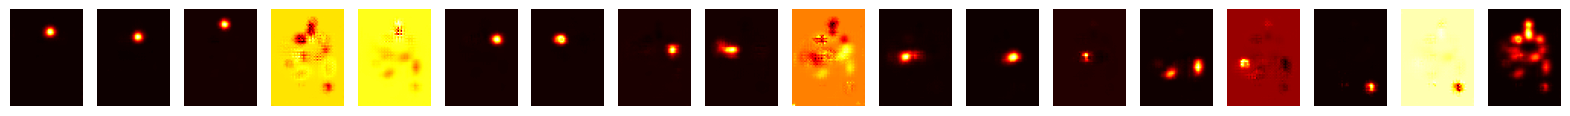

In [9]:
dataset = dataset_test
loss_val = 0
acc = 0
count = 0
i = np.random.randint(0, len(dataset))
video, video_transformed, keypoints, keypoints_transformed, heatmaps = dataset[i]
image = video[1]
H, W, _ = image.shape
decoder = UDPHeatmap(input_size=(W, H), heatmap_size=(48, 64))
image_transformed = video_transformed[1]
video_transformed = video_transformed.to(device).unsqueeze(0)
show_image(image, keypoints)
with torch.no_grad():
    pred_heatmaps = model.predict(video_transformed)
    show_image(image, heatmaps=pred_heatmaps.squeeze(0).cpu().numpy())
    show_heatmaps(pred_heatmaps.squeeze(0).cpu().numpy())
    pred_heatmaps = model.denoise(video_transformed, pred_heatmaps)
    show_image(image, heatmaps=pred_heatmaps.squeeze(0).cpu().numpy())
    show_heatmaps(pred_heatmaps.squeeze(0).cpu().numpy())
    